In [1]:
import numpy as np
import tifffile
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import cv2
from scipy.interpolate import RegularGridInterpolator
import pickle

In [2]:
image = tifffile.imread(r"Z:\2_Data\LWJ\RUSH3D\Data\White\20240603\White_Step1965_Size2415_20X_C2\capture\C2\White_Step1965_Size2415_20X_S1_C2_2.tiff")
image.shape
# image = image[0]

(10748, 14304)

In [9]:
H,W=image.shape
centerX = W//2-1
centerY = H//2-1
H,W,centerX,centerY

(10748, 14304, 7151, 5373)

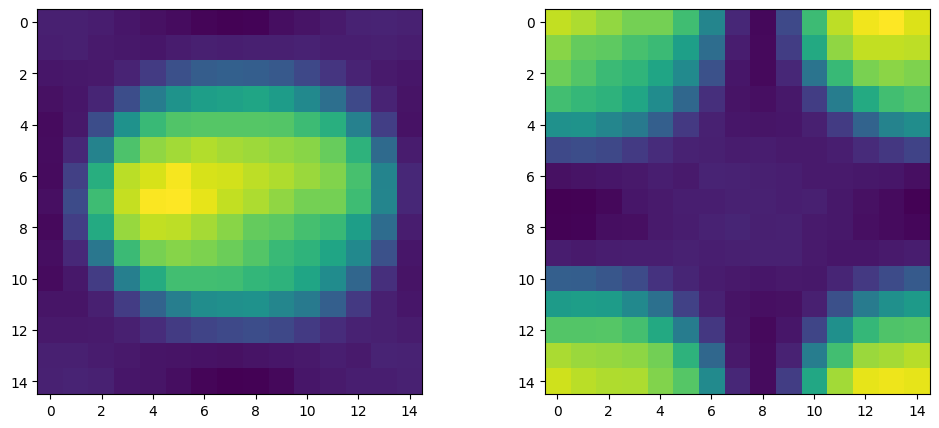

In [14]:
center=image[centerY-7:centerY+8,centerX-7:centerX+8]
center15=image[centerY:centerY+15,centerX:centerX+15]
fig,ax=plt.subplots(ncols=2,figsize=(12,5))
ax[0].imshow(center)
ax[1].imshow(center15)

In [15]:
gt=np.zeros_like(image)

for i in range(centerY%15,gt.shape[0],15):
    for j in range(centerX%15,gt.shape[1],15):
        center_coordinates = j,i
        radius = 6
        color = 10000
        thickness = cv2.FILLED
        cv2.circle(gt, center_coordinates, radius, color, thickness)
tifffile.imwrite("./gt.tif",gt.astype(np.uint16))

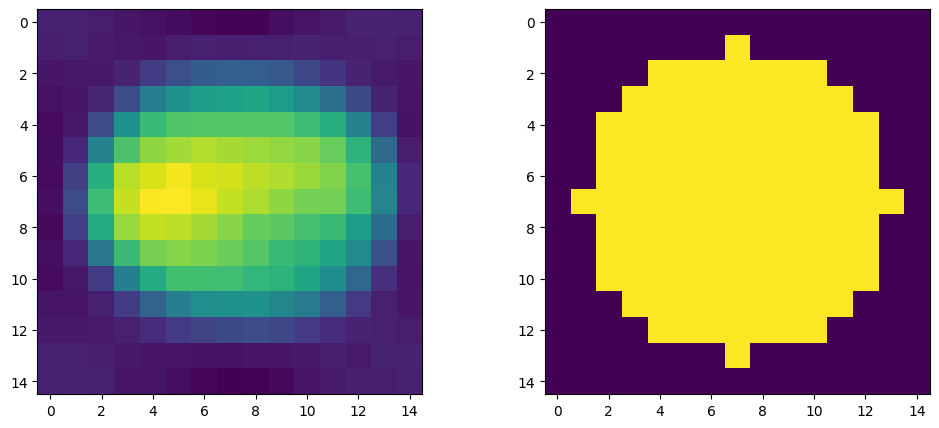

In [16]:
fig,ax=plt.subplots(ncols=2,figsize=(12,5))
ax[0].imshow(center)
ax[1].imshow(gt[centerY-7:centerY+8,centerX-7:centerX+8])

In [3]:
# The distort_model function applies distortion to a set of x and y coordinates based on the provided distortion parameters.
def distort_model(params, x,y):
    fx,fy,cx,cy,k1, k2, k3, p1, p2 = params
    matrix=np.array([[fx,0,cx],[0,fy,cy],[0,0,1]])
    objpoints=np.concatenate((x[:,np.newaxis],y[:,np.newaxis],np.ones_like(y[:,np.newaxis])),axis=1)
    objpoints_rotated=np.matmul(objpoints, matrix)
    objpoints_projected = objpoints_rotated[:, :2] / (objpoints_rotated[:, 2:] + 1e-17)
    shift=objpoints_projected-np.array([cx,cy])

    x_shifted = shift[:,0]
    y_shifted = shift[:,1]
    r2 = x_shifted**2 + y_shifted**2
    x_distorted = x_shifted * (1 + k1*r2 + k2*r2**2 + k3*r2**3) + 2*p1*x_shifted*y_shifted + p2*(r2 + 2*x_shifted**2) + cx
    y_distorted = y_shifted * (1 + k1*r2 + k2*r2**2 + k3*r2**3) + p1*(r2 + 2*y_shifted**2) + 2*p2*x_shifted*y_shifted + cy
    return x_distorted, y_distorted


# The error_function calculates the difference between the predicted and actual values of x and y.
def error_function(params, x, y, mapx, mapy):
    x_predicted, y_predicted = distort_model(params, x, y)
    return np.concatenate((x_predicted - mapx, y_predicted - mapy))

# The generate_params function generates distortion and undistortion parameters using a least squares optimization process.
def generate_params(x_distorted, y_distorted, x_ideal, y_ideal):
    params_initial = [0, 0, 0, 0, 0, 0, 0, 0, 0]

    result_undist = least_squares(error_function, params_initial, args=(x_distorted, y_distorted, x_ideal, y_ideal,))
    result_dist = least_squares(error_function, params_initial, args=( x_ideal, y_ideal,x_distorted, y_distorted,))

    return {"undistort":result_undist.x,"inv_undistort":result_dist.x}

In [40]:
# Initial distortion model according to the point pairs
# 20240429
# gt_coor=np.array([[1249,971],[1249,5096],[1249,9206],[1249,13331],[5374,971],[5374,5096],[5374,9206],[5374,13331],[9499,971],[9499,5096],[9499,9206],[9499,13331]])
# dist_coor=np.array([[1253,975.5],[1242,5092.5],[1242,9209.5],[1250,13329.5],[5375,968],[5374,5092],[5374,9211],[5373,13337],[9494,978],[9505,5094],[9505,9210],[9494,13327.5]])
# 20240513
# gt_coor=np.array([[1368,1152],[1368,5157],[1368,9147],[1368,13152],[5373,1152],[5372,5157],[5373,9147],[5373,13152],[9378,1152],[9378,5157],[9378,9147],[9378,13152]])
# dist_coor=np.array([[1369,1153],[1361,5153],[1361,9149],[1368,13149],[5373,1146],[5373,5152],[5373,9151],[5372,13157],[9376,1154],[9384,5154],[9384,9150],[9374,13148]])
# 20240522
# gt_coor=np.array([[1368,1152],[1368,5157],[1368,9147],[1368,13152],[5373,1152],[5372,5157],[5373,9147],[5373,13152],[9378,1152],[9378,5157],[9378,9147],[9378,13152]])
# dist_coor=np.array([[1370,1152.5],[1361,5153.5],[1361,9149],[1368,13149],[5374,1146],[5373,5152],[5373,9151],[5372.5,13157],[9377,1155],[9384,5154],[9384,9150],[9373,13150]])
# 20240604
gt_coor=np.array([[1368,1152],[1368,5157],[1368,9147],[1368,13152],[5373,1152],[5372,5157],[5373,9147],[5373,13152],[9378,1152],[9378,5157],[9378,9147],[9378,13152]])
dist_coor=np.array([[1369.5,1155],[1361,5152.5],[1361,9149.5],[1368,13152],[5373,1146],[5373,5152],[5372.5,9151],[5372,13157],[9375.5,1156],[9384,5153.5],[9384,9150],[9375,13150]])

x_ideal = (gt_coor[:,1]-centerX)/100
y_ideal = (gt_coor[:,0]-centerY)/100

x_distorted = (dist_coor[:,1]-centerX)/100
y_distorted = (dist_coor[:,0]-centerY)/100

params_new=generate_params(x_distorted,y_distorted,x_ideal,y_ideal)

In [26]:
# 反向过程（畸变过程）：规则的去畸变图像坐标(grid)-> 畸变后对应的不规则坐标值（float）
def undistort_coor(params):
    H, W = (10748,14304)
    gty,gtx = np.mgrid[:H, :W]
    gtxy = np.c_[gtx.ravel(), gty.ravel()]
    x_undistorted, y_undistorted = distort_model(params['inv_undistort'],(gtxy[:,0]-W//2)/100,(gtxy[:,1]-H//2)/100)
    x_undistorted=x_undistorted*100+W//2
    y_undistorted=y_undistorted*100+H//2
    return x_undistorted,y_undistorted

# 使用插值方法找到上述不规则坐标对应的像素值
def single_interpolate(image,x_undistorted,y_undistorted):
    centerB =image.copy()
    # desX=14000
    # desY=10000
    # sideX = (sx-desX)//2
    # sideY = (sy-desY)//2
    y = np.linspace(0, centerB.shape[0]-1, centerB.shape[0])
    x = np.linspace(0, centerB.shape[1]-1, centerB.shape[1])

    Ti = RegularGridInterpolator((y, x), centerB, method="linear", fill_value = 0)
    aa = Ti(np.stack([np.clip(y_undistorted,0,centerB.shape[0]-1), np.clip(x_undistorted,0,centerB.shape[1]-1)]).T)
    bb = aa.reshape(centerB.shape)
    return bb.astype(np.uint16)


In [41]:
# with open("./undistort_params_dict_points_240529.pkl",'rb') as file:
#     params_new=pickle.load(file)
# 反向过程（畸变过程）：规则的去畸变图像坐标(grid)-> 畸变后对应的不规则坐标值（float）
x_undistorted,y_undistorted = undistort_coor(params_new) 
# 使用插值方法找到上述不规则坐标对应的像素值
image_undistort = single_interpolate(image,x_undistorted,y_undistorted)
tifffile.imwrite("image_undistort.tif",image_undistort.astype(np.uint16)) 

In [ ]:
crop_H, crop_W = 10005, 14025
image_undistort_crop = image_undistort[centerY-crop_H//2:centerY+crop_H//2+1,centerX-crop_W//2:centerX+crop_W//2+1]
wigner = image_undistort_crop.reshape(667,15,935,15).transpose(1,3,0,2).reshape(225,667,935)
tifffile.imwrite("wigner.tif",wigner.astype(np.uint16)) 

In [42]:
from datetime import datetime
with open("undistort_params_dict_points_"+datetime.now().strftime("%y%m%d")+".pkl",'wb') as f:
    pickle.dump(params_new,f)